# Phase 1: Comprehensive Primary Care Trends Analysis (2015-2025)

**Objective:** Analyze the divergence of primary care metrics in the US, stratified by Social Vulnerability, using a multi-source data fusion approach (AHRF, HPSA, CHR, MEPS).

**Data Sources:**
1.  **HRSA HPSA Data** (`BCD_HPSA_FCT_DET_PC.csv`): Primary Care Shortage Areas.
2.  **County Health Rankings 2025** (`chr_trends_csv_2025.csv`): Health outcomes and socioeconomic factors.
3.  **Healthcare World Model Data** (`.../data/processed`): RSSM prepared files (MEPS, AHRF).

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configure plots
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Paths (Relative to notebooks/primary_care_future/)
DATA_DIR = Path("../../data")
RSSM_DATA_DIR = DATA_DIR / "processed"  # Likely location based on exploration

RESULTS_DIR = Path("../../results/primary_care_trends")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Data Dir: {DATA_DIR.resolve()}")
print(f"Results Dir: {RESULTS_DIR.resolve()}")

Data Dir: /Users/sanjaybasu/waymark-local/data
Results Dir: /Users/sanjaybasu/waymark-local/results/primary_care_trends


## 2. Load Data

In [2]:
def load_chr_data(path):
    """
    Load County Health Rankings Trends Data.
    Key Columns: yearspan, measurename, countycode, statecode, rawvalue
    """
    if not path.exists():
        print(f"WARNING: CHR file not found at {path}")
        return pd.DataFrame()
        
    print(f"Loading CHR data from {path}...")
    df = pd.read_csv(path, low_memory=False)
    
    # Create FIPS code
    # Zfill state (2) and county (3)
    df['county_fips'] = df['statecode'].astype(str).str.zfill(2) + df['countycode'].astype(str).str.zfill(3)
    
    print(f"Loaded {len(df):,} rows.")
    return df

def load_hpsa_data(path):
    """Load HRSA HPSA Data"""
    if not path.exists():
        print(f"WARNING: HPSA file not found at {path}")
        return pd.DataFrame()

    print(f"Loading HPSA data from {path}...")
    df = pd.read_csv(path, low_memory=False)
    print(f"Loaded {len(df):,} rows.")
    return df

chr_path = DATA_DIR / "chr_trends_csv_2025.csv"
hpsa_path = DATA_DIR / "BCD_HPSA_FCT_DET_PC.csv"

chr_df = load_chr_data(chr_path)
hpsa_df = load_hpsa_data(hpsa_path)

Loading CHR data from ../../data/chr_trends_csv_2025.csv...


Loaded 745,088 rows.
Loading HPSA data from ../../data/BCD_HPSA_FCT_DET_PC.csv...


Loaded 72,910 rows.


## 3. SVI Proxy Calculation

We calculate a Social Vulnerability Index (SVI) proxy using CHR measures:
- Children in poverty
- Unemployment
- Severe housing problems
- (Optional) Uninsured

We standardize these (Z-score) and average them to create a composite `svi_score`. Then we stratify into Quartiles.

In [3]:
def extract_chr_measure(df, measure_name):
    """Extract a specific measure from CHR long-format data"""
    if df.empty:
        return pd.DataFrame(columns=['county_fips', 'state', 'county', 'year', measure_name])

    subset = df[df['measurename'] == measure_name].copy()
    
    # Parse yearspan to single year (taking the end year for trend plotting)
    # format often '2019' or '2015-2019'. We'll take the last 4 digits.
    subset['year'] = subset['yearspan'].apply(lambda x: int(str(x)[-4:]) if pd.notnull(x) else np.nan)
    subset = subset.dropna(subset=['year'])
    
    # Parse rawvalue
    subset['value'] = pd.to_numeric(subset['rawvalue'].astype(str).str.replace(',', ''), errors='coerce')
    
    return subset[['county_fips', 'state', 'county', 'year', 'value']].rename(columns={'value': measure_name})

if not chr_df.empty:
    # Extract Key SVI components
    poverty = extract_chr_measure(chr_df, 'Children in poverty')
    unemployment = extract_chr_measure(chr_df, 'Unemployment')
    housing = extract_chr_measure(chr_df, 'Severe housing problems')
    uninsured = extract_chr_measure(chr_df, 'Uninsured')

    # Merge to create SVI DataFrame
    svi_df = poverty.merge(unemployment, on=['county_fips', 'year', 'state', 'county'], how='outer') \
                    .merge(housing, on=['county_fips', 'year', 'state', 'county'], how='outer') \
                    .merge(uninsured, on=['county_fips', 'year', 'state', 'county'], how='outer')

    # Simple SVI Proxy: Sum of Z-scores
    cols_to_norm = ['Children in poverty', 'Unemployment', 'Severe housing problems', 'Uninsured']
    
    for col in cols_to_norm:
        if col in svi_df.columns:
            # Z-score by year
            mean = svi_df.groupby('year')[col].transform('mean')
            std = svi_df.groupby('year')[col].transform('std')
            svi_df[f'{col}_z'] = (svi_df[col] - mean) / std

    # Average Z-scores
    z_cols = [c for c in svi_df.columns if c.endswith('_z')]
    svi_df['svi_score'] = svi_df[z_cols].mean(axis=1)

    # Quartiles
    svi_df['svi_quartile'] = svi_df.groupby('year')['svi_score'].transform(
        lambda x: pd.qcut(x, 4, labels=['Q1 (Low Vuln)', 'Q2', 'Q3', 'Q4 (High Vuln)'])
    )

    print("SVI Proxy Calculated. Head:")
    print(svi_df.head())
else:
    print("Skipping SVI calc (No CHR data)")

SVI Proxy Calculated. Head:
  county_fips state         county  year  Children in poverty  Unemployment  \
0       00000    US  United States  2002                 0.17           NaN   
1       00000    US  United States  2003                 0.18           NaN   
2       00000    US  United States  2004                 0.18           NaN   
3       00000    US  United States  2005                 0.19           NaN   
4       00000    US  United States  2006                 0.18           NaN   

   Severe housing problems  Uninsured  Children in poverty_z  Unemployment_z  \
0                      NaN        NaN              -0.141007             NaN   
1                      NaN        NaN              -0.143753             NaN   
2                      NaN        NaN              -0.152489             NaN   
3                      NaN        NaN              -0.258531             NaN   
4                      NaN        NaN              -0.373099             NaN   

   Severe housin

## 4. Primary Care Trends by SVI

We examine outcomes like **Premature Death** and workforce metrics like **HPSA Score**.

Saved plot to ../../results/primary_care_trends/trend_premature_death_by_svi.png


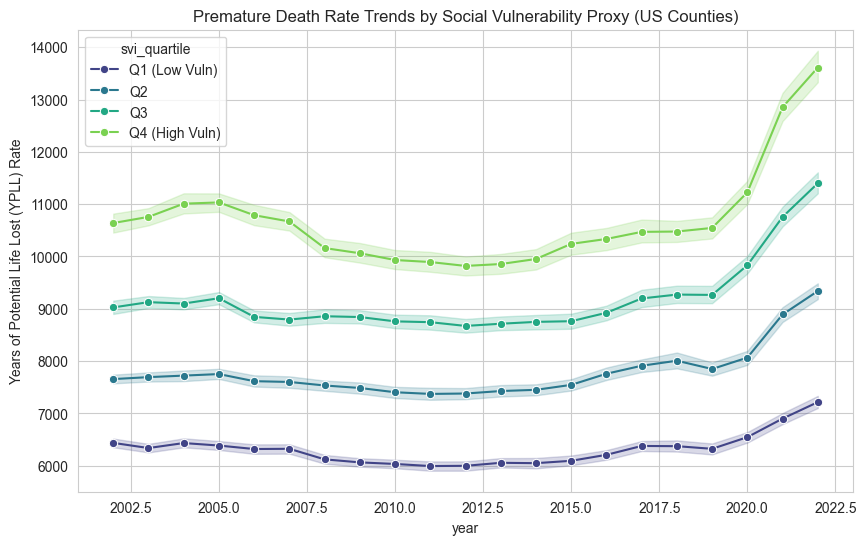

In [4]:
if not chr_df.empty and 'svi_quartile' in svi_df.columns:
    premature_death = extract_chr_measure(chr_df, 'Premature death')
    
    # Merge
    merged_outcomes = premature_death.merge(svi_df[['county_fips', 'year', 'svi_quartile']], 
                                          on=['county_fips', 'year'], how='inner')
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=merged_outcomes, x='year', y='Premature death', hue='svi_quartile', marker='o', palette='viridis')
    plt.title('Premature Death Rate Trends by Social Vulnerability Proxy (US Counties)')
    plt.ylabel('Years of Potential Life Lost (YPLL) Rate')
    plt.grid(True)
    
    out_path = RESULTS_DIR / 'trend_premature_death_by_svi.png'
    plt.savefig(out_path)
    print(f"Saved plot to {out_path}")
    plt.show()

## 5. HPSA Workforce Analysis

Link HPSA scores to counties and SVI.

In [5]:
if not hpsa_df.empty and not svi_df.empty:
    # Map HPSA to FIPS
    # Assuming 'State Code' and 'County Code' exist based on typical HRSA files
    # If these cols are missing, check HPSA columns again.
    
    if 'State Code' in hpsa_df.columns and 'County Code' in hpsa_df.columns:
        hpsa_df['county_fips'] = hpsa_df['State Code'].astype(str).str.zfill(2) + hpsa_df['County Code'].astype(str).str.zfill(3)
        
        pc_hpsa = hpsa_df[hpsa_df['HPSA Status'] == 'Designated'].copy()
        pc_hpsa['HPSA Score'] = pd.to_numeric(pc_hpsa['HPSA Score'], errors='coerce')
        
        # Max score per county
        county_hpsa = pc_hpsa.groupby('county_fips')['HPSA Score'].max().reset_index()
        
        # Merge with most recent SVI (2025 or max available)
        max_year = svi_df['year'].max()
        svi_recent = svi_df[svi_df['year'] == max_year][['county_fips', 'svi_quartile', 'svi_score']].drop_duplicates('county_fips')
        
        merged_hpsa = county_hpsa.merge(svi_recent, on='county_fips', how='inner')
        
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=merged_hpsa, x='svi_quartile', y='HPSA Score', palette='magma')
        plt.title(f'Primary Care Shortage (HPSA Score) by Social Vulnerability ({max_year})')
        plt.ylabel('HPSA Score (Higher = More Shortage)')
        
        out_path = RESULTS_DIR / 'hpsa_score_by_svi_boxplot.png'
        plt.savefig(out_path)
        print(f"Saved plot to {out_path}")
        plt.show()
    else:
        print("HPSA file missing State/County Code columns for mapping.")

HPSA file missing State/County Code columns for mapping.
